In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("final.csv")

In [3]:
df.head()

,qs,difficulty
0,"For 10 points, name this native of Rokovoko an...",college
1,It is more closely related to Dalmatian than t...,college
2,"For 10 points, name this state, home to Contin...",college
3,"For 10 points, name this author of ""The Fixati...",college
4,"For 10 points, identify this novel subtitled T...",college


In [4]:
df = df.dropna()

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [10]:
vocab_size = 5000 
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out ofVocabulary

In [11]:
qs_list = []
labels = []

for idx,row in df.iterrows():
    labels.append(row['difficulty'])
    qs = row['qs']
    qs = qs.lower()
    qs = ' '.join(word for word in qs.split() if word not in STOPWORDS)
    qs_list.append(qs)
        

In [12]:
qs_list[4]

'10 points, identify novel subtitled modern prometheus, mary shelley work creating certain monster.'

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(qs_list)
word_index = tokenizer.word_index

In [15]:
qs_sequences = tokenizer.texts_to_sequences(qs_list)

In [16]:
qs_padded = pad_sequences(qs_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
qs_padded[1]

array([3405, 1512,    1,   90,  158,  237,  116,    1,    1,    1,    1,
          1,    1,    1,    1,    1,  287, 1208,    1,  948,  584,    4,
          3,    2,    1, 1999,  280,  964, 4374,    1,    1,  427, 1789,
        237, 1999,    1,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [18]:
print(set(labels))

{'high_school', 'college'}


In [19]:
# 0 for college, 1 for high school
tokenized_labels = []
for entry in labels:
    if entry == 'high_school':
        tokenized_labels.append(1)
    else:
        tokenized_labels.append(0)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(qs_padded,tokenized_labels, test_size = 0.10, random_state = 42)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

In [23]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 386,306
Trainable params: 386,306
Non-trainable params: 0
_________________________________________________________________


In [24]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

In [26]:
epochs = 5
batch_size = 64
Y_train = np.array(Y_train)
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
1073/1073 [==============================] - 308s 283ms/step - loss: 0.6453 - accuracy: 0.6070 - val_loss: 0.6016 - val_accuracy: 0.6510
Epoch 2/5
1073/1073 [==============================] - 306s 286ms/step - loss: 0.5755 - accuracy: 0.6834 - val_loss: 0.6088 - val_accuracy: 0.6608
Epoch 3/5
1073/1073 [==============================] - 306s 285ms/step - loss: 0.5524 - accuracy: 0.7054 - val_loss: 0.6051 - val_accuracy: 0.6617
Epoch 4/5
1073/1073 [==============================] - 305s 284ms/step - loss: 0.5369 - accuracy: 0.7181 - val_loss: 0.6103 - val_accuracy: 0.6651
Epoch 5/5
1073/1073 [==============================] - 304s 283ms/step - loss: 0.5218 - accuracy: 0.7289 - val_loss: 0.6104 - val_accuracy: 0.6666


In [28]:
accr = model.evaluate(X_test,np.array(Y_test))
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

265/265 [==============================] - 11s 41ms/step - loss: 0.6165 - accuracy: 0.6620
Test set
  Loss: 0.617
  Accuracy: 0.662


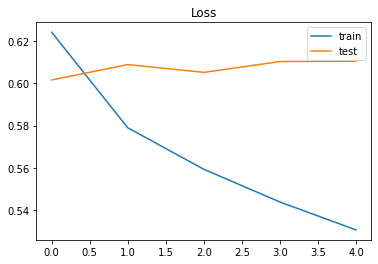

In [30]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

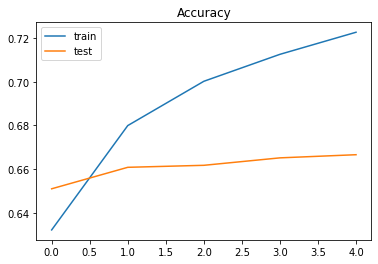

In [32]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();